# **IMPORT MODULES/FUNCTIONS/LOAD DATA**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import torch

from efficient_kan.src.efficient_kan import KAN
#from faster_kan.fastkan.fastkan import FastKAN
#from kan import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
from functions import (momentos, create_and_delay_pulse_pair, create_position, set_seed, 
                       calculate_gaussian_center_sigma, normalize, normalize_given_params, 
                       plot_gaussian, get_gaussian_params, interpolate_pulses)
from functions_KAN import train_loop_KAN
from Models import MLP_Torch, train_loop_MLP

In [3]:
# Load data 
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/Na22_filtered_data/'

train_data = np.load(os.path.join(dir,'Na22_train.npz'))['data']
val_data = np.load(os.path.join(dir, 'Na22_val.npz'))['data']
test_data = np.load(os.path.join(dir, 'Na22_test_val.npz'))['data']

# **IMPORTANT DEFINITIONS**

In [4]:
delay_steps = 30  # Max number of steps to delay pulses
moments_order = 5  # Max order of moments used
set_seed(42) #Fix seeds
nbins = 91 #Num bins for all histograms
create_positions = 0 # Wether to create new_source positions. (0 = YES, 1 = NO)                           
t_shift = 8 #Time steps to move for the new positions
normalization_method = 'standardization'
EXTRASAMPLING = 8
start = 47*EXTRASAMPLING 
stop = 74*EXTRASAMPLING 
epochs = 50
Num_Neurons = 64

# **INTERPOLATION**

In [5]:
new_train, new_time_step =  interpolate_pulses(train_data, EXTRASAMPLING = EXTRASAMPLING, time_step = 0.2)
new_val, new_time_step =  interpolate_pulses(val_data, EXTRASAMPLING = EXTRASAMPLING, time_step = 0.2)
new_test, new_time_step =  interpolate_pulses(test_data, EXTRASAMPLING = EXTRASAMPLING, time_step = 0.2)

# Align the pulses 
align_steps = 20

new_train[:,:,1] = np.roll(new_train[:,:,1], align_steps)
new_val[:,:,1] = np.roll(new_val[:,:,1], align_steps)
new_test[:,:,1] = np.roll(new_test[:,:,1], align_steps)

new_train[:,:align_steps,1] = np.random.normal(scale = 1e-6, size = align_steps)
new_val[:,:align_steps,1] = np.random.normal(scale = 1e-6, size = align_steps)
new_test[:,:align_steps,1] = np.random.normal(scale = 1e-6, size = align_steps)

print('New number of time points: %.d' % (new_train.shape[1]))
print('New time step: %.4f' % (new_time_step))

New number of time points: 4800
New time step: 0.0250


In [6]:
# Crop Waveform
train_data = new_train[:,start:stop,:] 
validation_data = new_val[:,start:stop,:] 
test_data = new_test[:,start:stop,:]
print('Número de casos de entrenamiento: ', train_data.shape[0])
print('Número de casos de test: ', test_data.shape[0])

Número de casos de entrenamiento:  18000
Número de casos de test:  3075


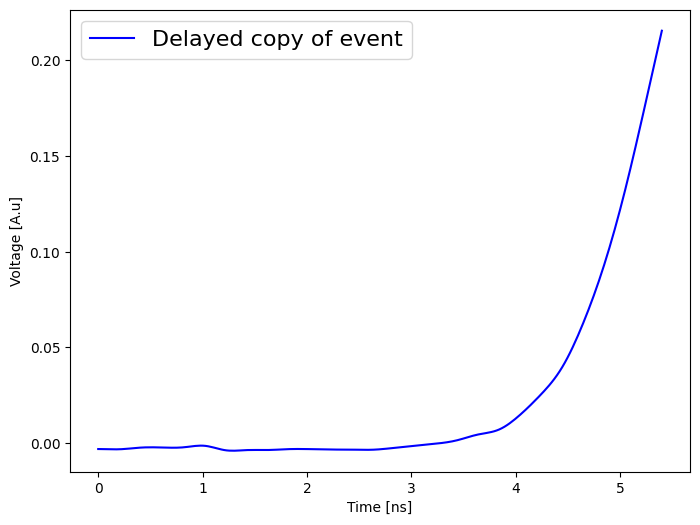

In [7]:
rolled_pulse = np.roll(train_data[0,:,0],300)
rolled_pulse[:300] = train_data[0,:300,0]
time = np.linspace(0,train_data.shape[1]*new_time_step, train_data.shape[1])

plt.figure(figsize=(8,6))
#plt.plot(time, new_data[0,:,0], 'r', label = 'Original event')
plt.plot(time, rolled_pulse, 'b-', label = 'Delayed copy of event')
plt.legend(prop={'size': 16})
plt.xlabel('Time [ns]')
plt.ylabel('Voltage [A.u]')
plt.savefig('/home/josea/delayed_pulse.png', dpi = 600)

# **DETECTORS**

In [8]:
# Create train set 
trainX_dec0, REF_train_dec0 = create_and_delay_pulse_pair(train_data[:,:,0], new_time_step, delay_steps = delay_steps, NOISE = False)
trainX_dec1, REF_train_dec1 = create_and_delay_pulse_pair(train_data[:,:,1], new_time_step, delay_steps = delay_steps, NOISE = False)

Text(0.5, 1.0, 'Detector 1')

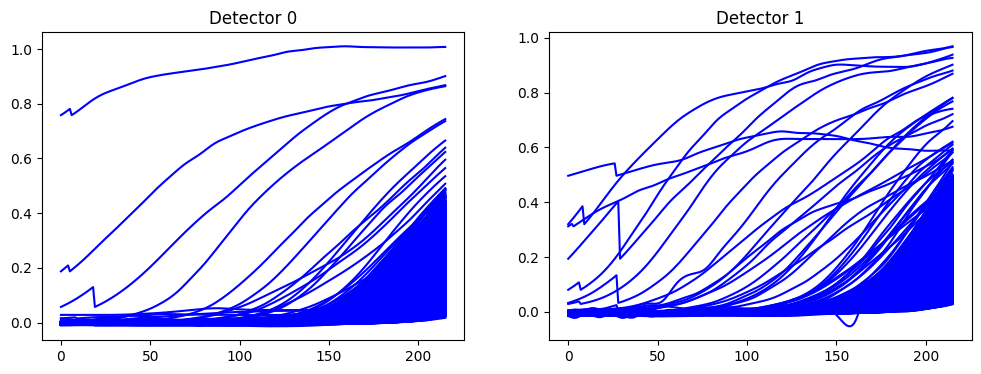

In [9]:
plt.figure(figsize = (12,4))

plt.subplot(121)
for i in range(trainX_dec0.shape[0]):
    plt.plot(trainX_dec0[i,:,0],'b-')
plt.title('Detector 0')

plt.subplot(122)
for i in range(trainX_dec1.shape[0]):
    plt.plot(trainX_dec1[i,:,0],'b-')
plt.title('Detector 1')

In [10]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0, order = moments_order) 
M_Train_dec1 = momentos(trainX_dec1, order = moments_order) 

#-------------------------------------------------------------- Normalize ---------------------------------------------------
M_Train_dec0, params_dec0 =  normalize(M_Train_dec0, method = normalization_method)
M_Train_dec1, params_dec1 =  normalize(M_Train_dec1, method = normalization_method)

#-------------------------------------------------------------- Print information ---------------------------------------------------
NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print("Normalization parameters detector 0:", params_dec0)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print("Normalization parameters detector 1:", params_dec1)

(18000, 5, 2) NM = 5
Normalization parameters detector 0: (array([4.27421757, 4.17460247, 3.91426836, 3.65204795, 3.41214528]), array([3.49115821, 2.77171597, 2.40133093, 2.14201492, 1.94114917]))
(18000, 5, 2) NM = 5
Normalization parameters detector 1: (array([4.7811722 , 4.70887664, 4.40803522, 4.10208133, 3.82350685]), array([4.07906685, 3.14533211, 2.66928562, 2.35091064, 2.11330479]))


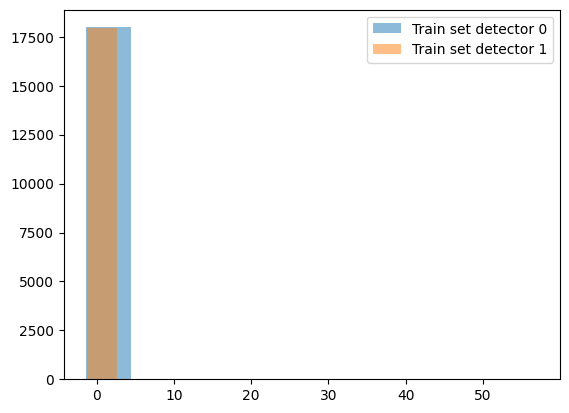

In [11]:
plt.hist(M_Train_dec0[:,0,0], alpha = 0.5, label = 'Train set detector 0');
plt.hist(M_Train_dec1[:,0,0], alpha = 0.5, label = 'Train set detector 1');
plt.legend()

# **FULL TOF (KAN)**

In [12]:
#-------------------------------- Create test set ---------------------------------------------------------
TEST_00 = test_data 
TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = False)
TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = False)
TEST_04 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = int(2*t_shift), NOISE = False)
TEST_40 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = int(2*t_shift), NOISE = False)
TEST = np.concatenate((TEST_02, TEST_00, TEST_20, TEST_04, TEST_40), axis = 0)


MOMENTS_TEST = momentos(TEST, order = moments_order)
MOMENTS_TEST_norm_dec0 = normalize_given_params(MOMENTS_TEST, params_dec0, channel = 0, method = normalization_method)
MOMENTS_TEST_norm_dec1 = normalize_given_params(MOMENTS_TEST, params_dec1, channel = 1, method = normalization_method)
MOMENTS_TEST = np.stack((MOMENTS_TEST_norm_dec0, MOMENTS_TEST_norm_dec1), axis = -1)

In [13]:
# Define model parameters
architecture = [NM, 5, 1, 1]   
grid_size = 5   # Efficient KAN uses grid size 5
k_order = 3

# Initialize model
#model_dec0 = KAN(width = architecture, grid = grid_size, k = k_order, seed = 0)
#model_dec1 = KAN(width = architecture, grid = grid_size, k = k_order, seed = 0)

model_dec0 = KAN(architecture)
model_dec1 = KAN(architecture)

#model_dec0 = MLP_Torch(NM = NM, NN = Num_Neurons, STD_INIT = 0.5)
#model_dec1 = MLP_Torch(NM = NM, NN = Num_Neurons, STD_INIT = 0.5)

In [14]:
# Create Dataset
train_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec0).float(), torch.from_numpy(np.expand_dims(REF_train_dec0, axis = -1)).float())
train_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec1).float(), torch.from_numpy(np.expand_dims(REF_train_dec1, axis = -1)).float())

# Create DataLoaders
train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = 32, shuffle = True)
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = 32, shuffle = True)

optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = 5e-3) 
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = 5e-3)  

val_dec0, REF_val_dec0 = create_and_delay_pulse_pair(validation_data[:,:,0], new_time_step, delay_steps = delay_steps, NOISE = False)
val_dec1, REF_val_dec1 = create_and_delay_pulse_pair(validation_data[:,:,1], new_time_step, delay_steps = delay_steps, NOISE = False)
M_Val_dec0 = momentos(val_dec0, order = moments_order) 
M_Val_dec1 = momentos(val_dec1, order = moments_order) 

M_Val_dec0_channel0 =  normalize_given_params(M_Val_dec0, params_dec0, channel = 0, method = normalization_method)
M_Val_dec0_channel1 =  normalize_given_params(M_Val_dec0, params_dec0, channel = 1, method = normalization_method)
M_Val_dec0 = np.stack((M_Val_dec0_channel0, M_Val_dec0_channel1), axis = -1)

M_Val_dec1_channel0 =  normalize_given_params(M_Val_dec1, params_dec1, channel = 0, method = normalization_method)
M_Val_dec1_channel1 =  normalize_given_params(M_Val_dec1, params_dec1, channel = 1, method = normalization_method)
M_Val_dec1 = np.stack((M_Val_dec1_channel0, M_Val_dec1_channel1), axis = -1)

val_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(M_Val_dec0).float(), torch.from_numpy(np.expand_dims(REF_val_dec0, axis = -1)).float())
val_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(M_Val_dec1).float(), torch.from_numpy(np.expand_dims(REF_val_dec1, axis = -1)).float())

val_loader_dec0 = torch.utils.data.DataLoader(val_dataset_dec0, batch_size = 32, shuffle = True)
val_loader_dec1 = torch.utils.data.DataLoader(val_dataset_dec1, batch_size = 32, shuffle = True)

/home/josea/.local/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 63 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [15]:
# Execute train loop
loss_dec0, val_loss_dec0, test_dec0, val_dec0 = train_loop_KAN(model_dec0, optimizer_dec0, train_loader_dec0, val_loader_dec0, torch.tensor(MOMENTS_TEST[:,:,0]).float(), EPOCHS = epochs, name = 'KAN_models/model_dec0', save = False) 
loss_dec1, val_loss_dec1, test_dec1, val_dec1 = train_loop_KAN(model_dec1, optimizer_dec1, train_loader_dec1, val_loader_dec1, torch.tensor(MOMENTS_TEST[:,:,1]).float(), EPOCHS = epochs, name = 'KAN_models/model_dec1', save = False)
#loss_dec0, val_loss_dec0, test_dec0 = train_loop_MLP(model_dec0, optimizer_dec0, train_loader_dec0, val_loader_dec0, torch.tensor(MOMENTS_TEST[:,:,0]).float(), EPOCHS = epochs, name = 'KAN_models/model_dec0', save = False) 
#loss_dec1, val_loss_dec1, test_dec1 = train_loop_MLP(model_dec1, optimizer_dec1, train_loader_dec1, val_loader_dec1, torch.tensor(MOMENTS_TEST[:,:,1]).float(), EPOCHS = epochs, name = 'KAN_models/model_dec1', save = False)

EPOCH 1:
LOSS train 0.0760298362373975
LOSS val 0.012562583200633526
EPOCH 2:
LOSS train 0.012092180605514594
LOSS val 0.011825365014374256
EPOCH 3:
LOSS train 0.01089588172905822
LOSS val 0.01181735284626484
EPOCH 4:
LOSS train 0.009922391700278803
LOSS val 0.00920846126973629
EPOCH 5:
LOSS train 0.009045588400969232
LOSS val 0.008482045494019985
EPOCH 6:
LOSS train 0.011026229704424182
LOSS val 0.014248211868107319
EPOCH 7:
LOSS train 0.010426399267409294
LOSS val 0.0075031304731965065
EPOCH 8:
LOSS train 0.011900687806943488
LOSS val 0.008529971353709698
EPOCH 9:
LOSS train 0.008582862662267252
LOSS val 0.007120963651686907
EPOCH 10:
LOSS train 0.007936566040005873
LOSS val 0.008871984668076038
EPOCH 11:
LOSS train 0.00787452894815477
LOSS val 0.009088710881769657
EPOCH 12:
LOSS train 0.00808562579371207
LOSS val 0.010290422476828098
EPOCH 13:
LOSS train 0.007238279883774596
LOSS val 0.005933525040745735
EPOCH 14:
LOSS train 0.007140572431379826
LOSS val 0.008547243662178516
EPOCH 1

In [16]:
TOFN_V02 = test_dec0[:,:TEST_00.shape[0]] - test_dec1[:,:TEST_00.shape[0]]
TOFN_V00 = test_dec0[:,TEST_00.shape[0] : 2*TEST_00.shape[0]] - test_dec1[:, TEST_00.shape[0] : 2*TEST_00.shape[0]]
TOFN_V20 = test_dec0[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]] - test_dec1[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]]
TOFN_V04 = test_dec0[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]] - test_dec1[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]]
TOFN_V40 = test_dec0[:,4*TEST_00.shape[0]:] - test_dec1[:,4*TEST_00.shape[0]:]
    
# Calculate centered position 'centroid'
centroid_V00, sigmaN_V00 = calculate_gaussian_center_sigma(TOFN_V00, np.zeros((TOFN_V00.shape[0])), nbins = nbins) 

error_V02 = abs((TOFN_V02 - centroid_V00[:, np.newaxis] + 0.2))
error_V00 = abs((TOFN_V00 - centroid_V00[:, np.newaxis]))
error_V20 = abs((TOFN_V20 - centroid_V00[:, np.newaxis] - 0.2))
error_V04 = abs((TOFN_V04 - centroid_V00[:, np.newaxis] + 0.4))
error_V40 = abs((TOFN_V40 - centroid_V00[:, np.newaxis] - 0.4))

Error = np.concatenate((error_V02, error_V00, error_V20, error_V04, error_V40), axis = 1)   

0.08021971793794877


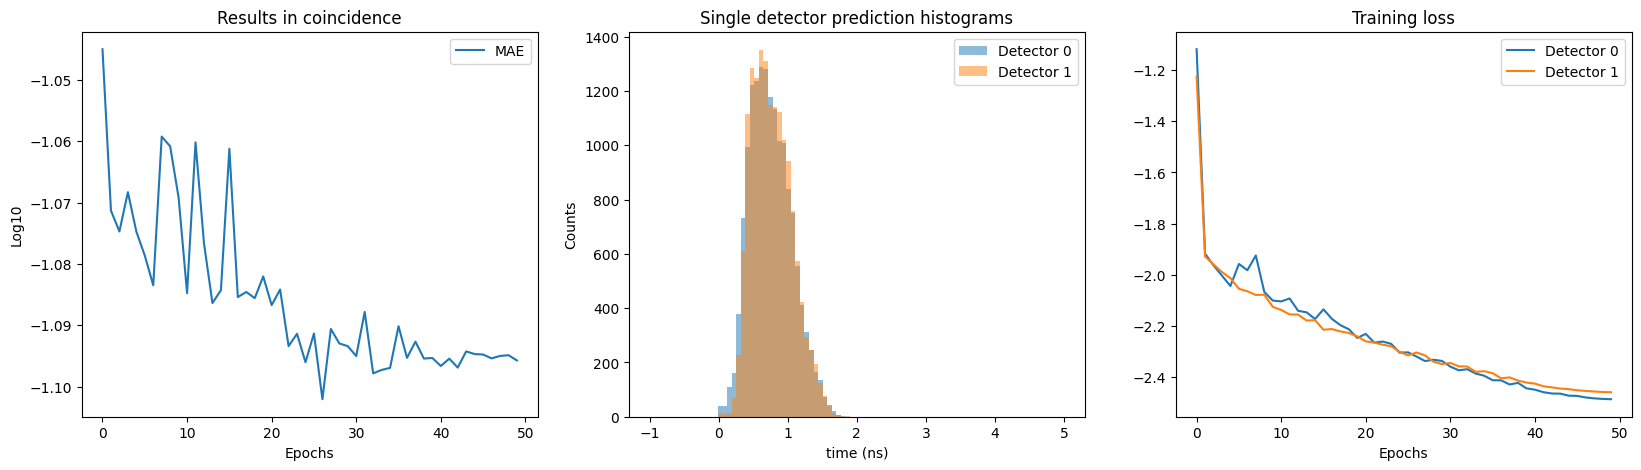

In [17]:
# Print MAE
MAE = np.mean(Error, axis = 1)
print(MAE[-1])

# PLot
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.plot(np.log10(MAE[:].astype('float64')), label = 'MAE')
plt.title('Results in coincidence')
plt.xlabel('Epochs')
plt.ylabel('Log10')
plt.legend()

plt.subplot(132)
plt.hist(test_dec0[-1, :], bins = nbins, range = [-1, 5], alpha = 0.5, label = 'Detector 0');
plt.hist(test_dec1[-1, :], bins = nbins, range = [-1, 5], alpha = 0.5, label = 'Detector 1');

plt.title('Single detector prediction histograms')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.legend()

plt.subplot(133)
plt.plot(np.log10(loss_dec0.astype('float32')), label = 'Detector 0')
plt.plot(np.log10(loss_dec1.astype('float32')), label = 'Detector 1')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.legend()

V40: CENTROID(ns) = 0.399 +/- 0.001  FWHM(ns) = 0.225 +/- 0.001
V20: CENTROID(ns) = 0.199 +/- 0.001  FWHM(ns) = 0.227 +/- 0.001
V00: CENTROID(ns) = -0.000 +/- 0.001  FWHM(ns) = 0.226 +/- 0.001
V02: CENTROID(ns) = -0.199 +/- 0.001  FWHM(ns) = 0.227 +/- 0.001
V04: CENTROID(ns) = -0.400 +/- 0.001  FWHM(ns) = 0.227 +/- 0.001



Text(0, 0.5, 'Counts')

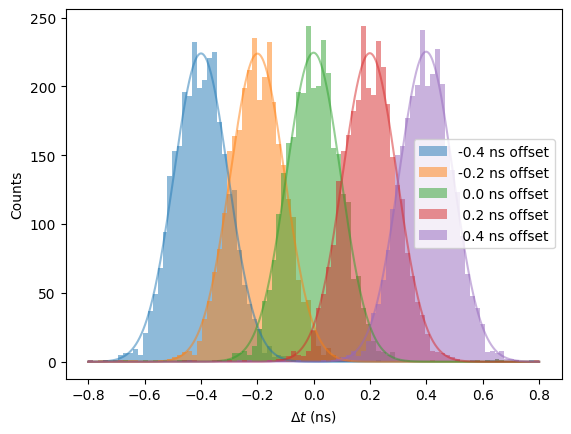

In [23]:
# Histogram and gaussian fit 
plot_gaussian(TOFN_V04[-1,:], centroid_V00[-1], range = 0.8, label = '-0.4 ns offset', nbins = nbins)
plot_gaussian(TOFN_V02[-1,:], centroid_V00[-1], range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOFN_V00[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOFN_V20[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.2 ns offset', nbins = nbins)
plot_gaussian(TOFN_V40[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.4 ns offset', nbins = nbins)

params_V04, errors_V04 = get_gaussian_params(TOFN_V04[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V02, errors_V02 = get_gaussian_params(TOFN_V02[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOFN_V00[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOFN_V20[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V40, errors_V40 = get_gaussian_params(TOFN_V40[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)

print("V40: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_V40[2], errors_V40[2], params_V40[3], errors_V40[3]))
print("V20: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))
print("V04: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_V04[2], errors_V04[2], params_V04[3], errors_V04[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')

0.0037503664294249624


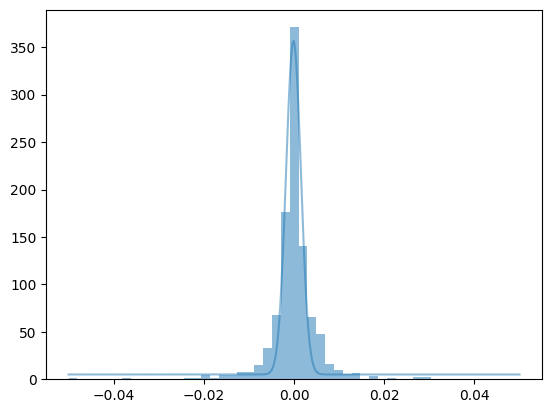

In [19]:
val_dec1 = model_dec1(torch.from_numpy(M_Val_dec1[:,:,0]).float().to(device)) - model_dec1(torch.from_numpy(M_Val_dec1[:,:,1]).float().to(device)) 
err_val = np.squeeze(val_dec1.cpu().detach().numpy()) - REF_val_dec1
plot_gaussian(err_val, np.zeros_like(err_val), range = 0.05, nbins = 51)
params, errors = get_gaussian_params(err_val, np.zeros_like(err_val), range = 0.05, nbins = nbins)
print(params[3])

In [20]:
import time

time_test = np.tile(trainX_dec0[0,:,:], (1000000, 1,1))


time_list_moments = []
# Start timer moments
for i in range(10):
    start_time_momentos = time.time()
    M_time_test = momentos(time_test, order = moments_order)
    end_time_momentos = time.time()
    elapsed_time_momentos = end_time_momentos - start_time_momentos
    time_list_moments.append(elapsed_time_momentos)
time_array_moments = np.array(time_list_moments)

time_list_inference = []
# Start timer inference
for i in range(10):
    start_time_inference= time.time()
    with torch.no_grad():
        assert not torch.is_grad_enabled()
        output_time_test = model_dec0(torch.tensor(M_time_test[:,:,0]).float().to(device))
    end_time_inference = time.time()
    elapsed_time_inference = end_time_inference - start_time_inference
    time_list_inference.append(elapsed_time_inference)
time_array_inference = np.array(time_list_inference)



print('Elapsed time momentos:', np.mean(time_array_moments), np.std(time_array_moments))
print('Elapsed time inference:', np.mean(time_array_inference), np.std(time_array_inference))

Elapsed time momentos: 0.3213495254516602 0.051831585147458094
Elapsed time inference: 0.025920343399047852 0.004766792118982742


Text(0, 0.5, 'Absolute error')

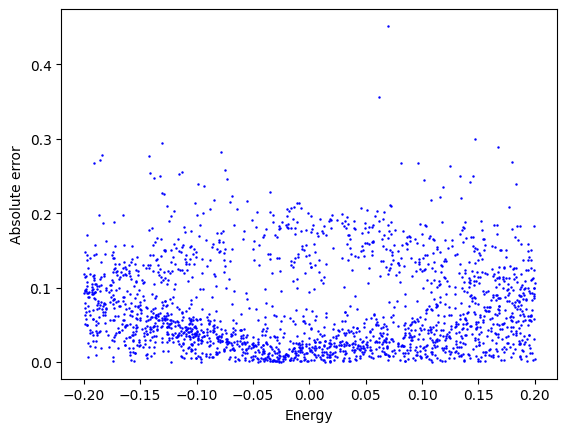

In [21]:
energy_diff = MOMENTS_TEST[:,0,0] - MOMENTS_TEST[:,0,1]

idx = np.where(abs(energy_diff) < 0.2)[0]
plt.plot(energy_diff[idx], Error[-1,idx], 'b.', markersize = 1.5)
plt.xlabel('Energy')
plt.ylabel('Absolute error')

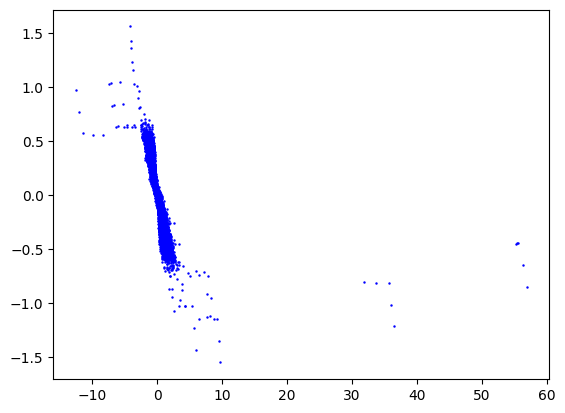

In [22]:
Moment0_diff = MOMENTS_TEST[:,0,0] - MOMENTS_TEST[:,0,1]
plt.plot(Moment0_diff, test_dec0[-1,:]-test_dec1[-1,:], 'b.', markersize = 1.5)